# Import Libraries

In [1]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
import os
import requests


#Define Dataset URL and Path

In [2]:
DATASET_URL = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
DATASET_PATH = './data/daily-min-temperatures.csv'


#Create Data Directory and Download Dataset

In [3]:
os.makedirs(os.path.dirname(DATASET_PATH), exist_ok=True)

if not os.path.exists(DATASET_PATH):
    response = requests.get(DATASET_URL)
    with open(DATASET_PATH, 'wb') as f:
        f.write(response.content)


# Helper Function to Plot Time Series

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


# Function to Parse Data from CSV File

In [5]:
def parse_data_from_file(filename):
    times = []
    temperatures = []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for i, row in enumerate(reader):
            times.append(i)  # Append the time step
            temperatures.append(float(row[1]))  # Append the temperature as a float

    return times, temperatures


# Global Variables Stored in a Dataclass

In [6]:
#dataclass
class G:
    TEMPERATURES_CSV = DATASET_PATH
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


# Plot the Time Series Data

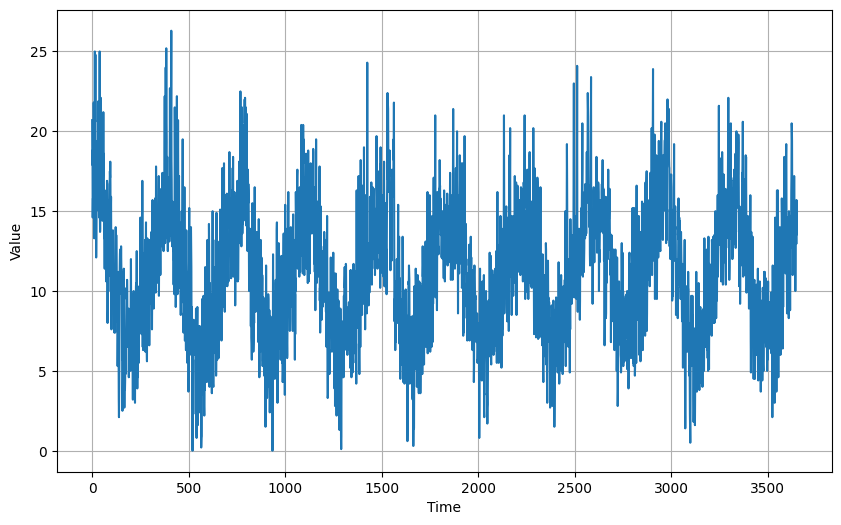

In [7]:
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()


# Function to Split Dataset into Training and Validation Sets

In [8]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid


# Split the Dataset

In [9]:
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)


# Function to Create a Windowed Dataset

In [10]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Prepare the Training Set

In [11]:
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)


# Function to Create the Model Architecture

In [12]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                               strides=1, padding="causal",
                               activation="relu",
                               input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1)
    ])
    return model


# Test the Uncompiled Model

In [13]:
uncompiled_model = create_uncompiled_model()

try:
    for x, y in train_set.take(1):
        uncompiled_model.predict(x)
    print("Your current architecture is compatible with the windowed dataset! :)")
except Exception as e:
    print(f"Your current architecture is incompatible with the windowed dataset: {e}")


1/1 [==============================] - 1s 725ms/step
Your current architecture is compatible with the windowed dataset! :)


# Function to Adjust the Learning Rate

Epoch 1/100
77/77 [==============================] - 7s 46ms/step - loss: 7.9876 - mae: 8.4843 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 4s 45ms/step - loss: 4.7076 - mae: 5.1888 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 4s 49ms/step - loss: 3.3272 - mae: 3.8003 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 4s 44ms/step - loss: 2.8445 - mae: 3.3122 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 4s 45ms/step - loss: 2.5332 - mae: 2.9945 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 4s 45ms/step - loss: 2.3135 - mae: 2.7700 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 3s 44ms/step - loss: 2.1345 - mae: 2.5913 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 3s 42ms/step - loss: 2.0333 - mae: 2.4893 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 4s 46ms/step - loss: 1.9386 - mae: 2.3930 - lr: 2.5

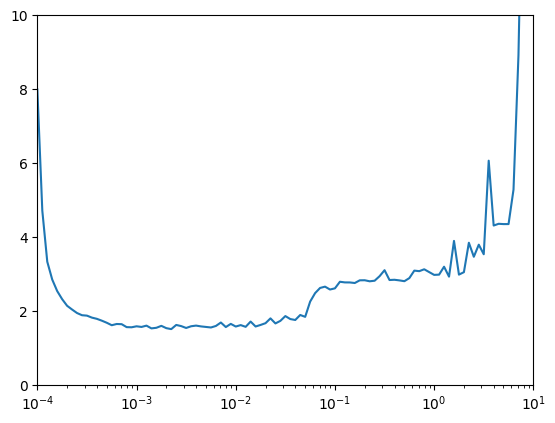

In [14]:
def adjust_learning_rate(dataset):
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

lr_history = adjust_learning_rate(train_set)
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])
plt.show()


# Function to Create and Compile the Model

In [15]:
def create_model():
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mae"])

    return model

model = create_model()
history = model.fit(train_set, epochs=50)


Epoch 1/50
77/77 [==============================] - 7s 52ms/step - loss: 3.7900 - mae: 4.2609
Epoch 2/50
77/77 [==============================] - 4s 52ms/step - loss: 2.1801 - mae: 2.6382
Epoch 3/50
77/77 [==============================] - 4s 51ms/step - loss: 1.8013 - mae: 2.2492
Epoch 4/50
77/77 [==============================] - 4s 53ms/step - loss: 1.6828 - mae: 2.1319
Epoch 5/50
77/77 [==============================] - 4s 52ms/step - loss: 1.6164 - mae: 2.0606
Epoch 6/50
77/77 [==============================] - 4s 50ms/step - loss: 1.5683 - mae: 2.0164
Epoch 7/50
77/77 [==============================] - 4s 50ms/step - loss: 1.5229 - mae: 1.9656
Epoch 8/50
77/77 [==============================] - 4s 48ms/step - loss: 1.5212 - mae: 1.9613
Epoch 9/50
77/77 [==============================] - 4s 47ms/step - loss: 1.5319 - mae: 1.9696
Epoch 10/50
77/77 [==============================] - 4s 50ms/step - loss: 1.5013 - mae: 1.9433
Epoch 11/50
77/77 [==============================] - 4s 55m

# Function to Compute Metrics

In [16]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae


# Function to Forecast Using the Model

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]


113/113 [==============================] - 3s 16ms/step


# Plot the Forecast

mse: 5.25, mae: 1.80 for forecast


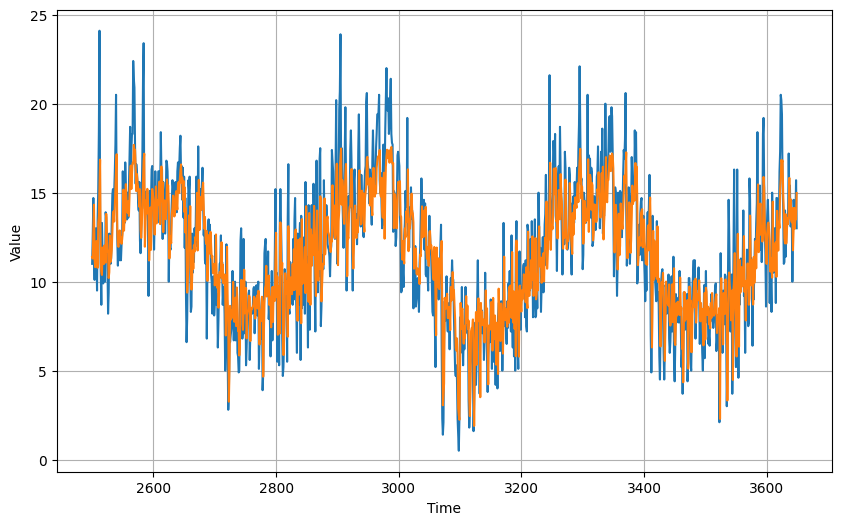

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")


# Save the model

In [ ]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/